In [1]:
!pip install geopy

In [92]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from urllib.request import urlopen

pd.set_option('display.max_columns',None)  # to show all the columns while printing the df
pd.set_option('display.max_rows',None)  # to show all the rows while printing the df

### Load the data

In [3]:
data = pd.read_csv("YourCabs.csv")
data.head()

,id,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,132512,22177,28,NaN,2,83.0,448.0,NaN,NaN,01-01-2013 02:00,0,0,01-01-2013 01:39,12.924150,77.672290,12.927320,77.635750,0
1,132513,21413,12,NaN,2,1010.0,540.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 02:25,12.966910,77.749350,12.927680,77.626640,0
2,132514,22178,12,NaN,2,1301.0,1034.0,NaN,NaN,01-01-2013 03:30,0,0,01-01-2013 03:08,12.937222,77.626915,13.047926,77.597766,0
3,132515,13034,12,NaN,2,768.0,398.0,NaN,NaN,01-01-2013 05:45,0,0,01-01-2013 04:39,12.989990,77.553320,12.971430,77.639140,0
4,132517,22180,12,NaN,2,1365.0,849.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 07:53,12.845653,77.677925,12.954340,77.600720,0


### Verify the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43431 entries, 0 to 43430
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   43431 non-null  int64  
 1   user_id              43431 non-null  int64  
 2   vehicle_model_id     43431 non-null  int64  
 3   package_id           7550 non-null   float64
 4   travel_type_id       43431 non-null  int64  
 5   from_area_id         43343 non-null  float64
 6   to_area_id           34293 non-null  float64
 7   from_city_id         16345 non-null  float64
 8   to_city_id           1588 non-null   float64
 9   from_date            43431 non-null  object 
 10  online_booking       43431 non-null  int64  
 11  mobile_site_booking  43431 non-null  int64  
 12  booking_created      43431 non-null  object 
 13  from_lat             43338 non-null  float64
 14  from_long            43338 non-null  float64
 15  to_lat               34293 non-null 

### Dropping columns having unique values and PII

In [5]:
data=data.drop(['id','user_id'],axis=1)

### Filtering out travel_type_id=2

In [6]:
data_tt2 = data[data['travel_type_id'] == 2] # filtering the data having travel_type_id 2
data_tt2.head()

,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,28,NaN,2,83.0,448.0,NaN,NaN,01-01-2013 02:00,0,0,01-01-2013 01:39,12.924150,77.672290,12.927320,77.635750,0
1,12,NaN,2,1010.0,540.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 02:25,12.966910,77.749350,12.927680,77.626640,0
2,12,NaN,2,1301.0,1034.0,NaN,NaN,01-01-2013 03:30,0,0,01-01-2013 03:08,12.937222,77.626915,13.047926,77.597766,0
3,12,NaN,2,768.0,398.0,NaN,NaN,01-01-2013 05:45,0,0,01-01-2013 04:39,12.989990,77.553320,12.971430,77.639140,0
4,12,NaN,2,1365.0,849.0,NaN,NaN,01-01-2013 09:00,0,0,01-01-2013 07:53,12.845653,77.677925,12.954340,77.600720,0


### Dropping travel_type_id which is no more required

In [7]:
data_tt2 = data_tt2.drop(['travel_type_id'],axis=1)

### Checking missing values

In [8]:
data_tt2.isnull().sum()

vehicle_model_id           0
package_id             34292
from_area_id               0
to_area_id                 0
from_city_id           19788
to_city_id             34292
from_date                  0
online_booking             0
mobile_site_booking        0
booking_created            0
from_lat                   0
from_long                  0
to_lat                     0
to_long                    0
Car_Cancellation           0
dtype: int64

### Analysing data proportion in categorical variables

In [9]:
data_tt2['vehicle_model_id'].value_counts(normalize=True)*100

12    74.737548
85     5.954742
89     5.733116
28     4.207979
24     3.793888
65     2.574945
90     0.848594
23     0.752362
87     0.463665
86     0.297445
10     0.244955
64     0.230374
17     0.078736
91     0.072903
1      0.005832
54     0.002916
Name: vehicle_model_id, dtype: float64

In [10]:
data_tt2['package_id'].value_counts(normalize=True)*100

Series([], Name: package_id, dtype: float64)

In [11]:
data_tt2['from_area_id'].value_counts(normalize=True)*100

393.0     9.841946
571.0     3.493526
585.0     2.327073
293.0     2.216260
1384.0    1.746763
142.0     1.670944
1010.0    1.624286
83.0      1.621369
1096.0    1.192698
1026.0    1.017730
269.0     0.938995
1371.0    0.912749
58.0      0.909833
625.0     0.854427
689.0     0.825265
1330.0    0.813601
768.0     0.793188
271.0     0.793188
1068.0    0.778607
1056.0    0.761110
1017.0    0.726117
363.0     0.679459
1021.0    0.679459
396.0     0.656130
410.0     0.635717
168.0     0.624052
392.0     0.609472
105.0     0.606555
776.0     0.589059
458.0     0.583226
1365.0    0.577394
572.0     0.568646
450.0     0.548233
1390.0    0.545317
515.0     0.530736
1095.0    0.519072
353.0     0.513239
542.0     0.510323
1054.0    0.507407
1165.0    0.498659
1038.0    0.498659
61.0      0.495742
767.0     0.486994
1041.0    0.484078
89.0      0.481162
149.0     0.478246
949.0     0.478246
1084.0    0.452000
136.0     0.449084
977.0     0.446168
793.0     0.437420
590.0     0.431588
1089.0    0.

In [12]:
data_tt2['to_area_id'].value_counts(normalize=True)*100

393.0     25.594891
585.0      6.820833
1384.0     3.607255
571.0      1.936312
293.0      1.618453
1010.0     1.399743
83.0       1.064388
168.0      0.985653
1371.0     0.968156
452.0      0.962324
142.0      0.950659
1026.0     0.930246
1068.0     0.912749
572.0      0.904001
1021.0     0.804852
392.0      0.787356
1192.0     0.682375
1017.0     0.661962
58.0       0.641549
1096.0     0.632801
768.0      0.583226
271.0      0.568646
136.0      0.545317
1393.0     0.539484
1330.0     0.524904
625.0      0.521988
455.0      0.501575
269.0      0.484078
1056.0     0.478246
767.0      0.472413
344.0      0.457833
611.0      0.419923
376.0      0.417007
25.0       0.414091
105.0      0.408258
353.0      0.405342
1365.0     0.405342
218.0      0.399510
433.0      0.387846
1041.0     0.387846
458.0      0.382013
949.0      0.370349
448.0      0.367433
463.0      0.364517
776.0      0.358684
1054.0     0.355768
1390.0     0.332439
1254.0     0.320775
1084.0     0.314942
1281.0     0.306194


In [13]:
data_tt2['from_city_id'].value_counts(normalize=True)*100

15.0    100.0
Name: from_city_id, dtype: float64

In [14]:
data_tt2['to_city_id'].value_counts(normalize=True)*100

Series([], Name: to_city_id, dtype: float64)

In [15]:
data_tt2['online_booking'].value_counts(normalize=True)*100

0    63.694156
1    36.305844
Name: online_booking, dtype: float64

In [16]:
data_tt2['mobile_site_booking'].value_counts(normalize=True)*100

0    95.191298
1     4.808702
Name: mobile_site_booking, dtype: float64

##### Deleting vehicle_model_id, package_id, mobile_site_booking, from_city_id,to_city_id columns

In [17]:
### Delete the below columns due to:
### vehicle_model_id - improportionate data, leads to bias
### package_id - not required for travel_type_id = 2
### from_city_id - improportionate data and also not mandatory for travel_type_id = 2
### to_city_id - not required for travel_type_id = 2
### mobile_site_booking - improportionate data, leads to bias

data_tt2 = data_tt2.drop(['vehicle_model_id','package_id','from_city_id','to_city_id','mobile_site_booking'],axis=1)
data_tt2.head()

,from_area_id,to_area_id,from_date,online_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,83.0,448.0,01-01-2013 02:00,0,01-01-2013 01:39,12.924150,77.672290,12.927320,77.635750,0
1,1010.0,540.0,01-01-2013 09:00,0,01-01-2013 02:25,12.966910,77.749350,12.927680,77.626640,0
2,1301.0,1034.0,01-01-2013 03:30,0,01-01-2013 03:08,12.937222,77.626915,13.047926,77.597766,0
3,768.0,398.0,01-01-2013 05:45,0,01-01-2013 04:39,12.989990,77.553320,12.971430,77.639140,0
4,1365.0,849.0,01-01-2013 09:00,0,01-01-2013 07:53,12.845653,77.677925,12.954340,77.600720,0


### Treating and extracting info from Date columns

In [18]:
data_tt2['from_date_treated'] = pd.to_datetime(data_tt2['from_date'])
data_tt2['booking_date_treated'] = pd.to_datetime(data_tt2['booking_created'])
data_tt2.head()

,from_area_id,to_area_id,from_date,online_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation,from_date_treated,booking_date_treated
0,83.0,448.0,01-01-2013 02:00,0,01-01-2013 01:39,12.924150,77.672290,12.927320,77.635750,0,2013-01-01 02:00:00,2013-01-01 01:39:00
1,1010.0,540.0,01-01-2013 09:00,0,01-01-2013 02:25,12.966910,77.749350,12.927680,77.626640,0,2013-01-01 09:00:00,2013-01-01 02:25:00
2,1301.0,1034.0,01-01-2013 03:30,0,01-01-2013 03:08,12.937222,77.626915,13.047926,77.597766,0,2013-01-01 03:30:00,2013-01-01 03:08:00
3,768.0,398.0,01-01-2013 05:45,0,01-01-2013 04:39,12.989990,77.553320,12.971430,77.639140,0,2013-01-01 05:45:00,2013-01-01 04:39:00
4,1365.0,849.0,01-01-2013 09:00,0,01-01-2013 07:53,12.845653,77.677925,12.954340,77.600720,0,2013-01-01 09:00:00,2013-01-01 07:53:00


In [19]:
# After extracting required info in required format from date columns dropping the actual date columns in the data
data_tt2=data_tt2.drop(['from_date','booking_created'],axis=1)

#### Creating new columns from given date columns

In [20]:
data_tt2['waiting_period_min'] = (data_tt2['from_date_treated'] - data_tt2['booking_date_treated']).astype('timedelta64[m]') #new column waiting_period_min

data_tt2['travel_day'] = pd.to_datetime(data_tt2['from_date_treated']).dt.dayofweek #new column travel_day
data_tt2['travel_month'] = pd.to_datetime(data_tt2['from_date_treated']).dt.month #new column travel_month
data_tt2['booked_day'] = pd.to_datetime(data_tt2['booking_date_treated']).dt.dayofweek #new column booked_day
data_tt2['booked_month'] = pd.to_datetime(data_tt2['booking_date_treated']).dt.month #new column booked_month

cond = [(pd.to_datetime(data_tt2['from_date_treated']).dt.hour.between(5, 8)),
        (pd.to_datetime(data_tt2['from_date_treated']).dt.hour.between(9, 12)),
        (pd.to_datetime(data_tt2['from_date_treated']).dt.hour.between(13, 16)),
        (pd.to_datetime(data_tt2['from_date_treated']).dt.hour.between(17, 20)),
        ((pd.to_datetime(data_tt2['from_date_treated']).dt.hour.between(21, 24)) | (pd.to_datetime(data_tt2['from_date_treated']).dt.hour==0)),
        (pd.to_datetime(data_tt2['from_date_treated']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']

data_tt2['travel_hour'] = np.select(cond,values) #new column travel_hour


cond = [(pd.to_datetime(data_tt2['booking_date_treated']).dt.hour.between(5, 8)),
        (pd.to_datetime(data_tt2['booking_date_treated']).dt.hour.between(9, 12)),
        (pd.to_datetime(data_tt2['booking_date_treated']).dt.hour.between(13, 16)),
        (pd.to_datetime(data_tt2['booking_date_treated']).dt.hour.between(17, 20)),
        ((pd.to_datetime(data_tt2['booking_date_treated']).dt.hour.between(21, 24)) | (pd.to_datetime(data_tt2['booking_date_treated']).dt.hour==0)),
        (pd.to_datetime(data_tt2['booking_date_treated']).dt.hour.between(1, 4))]
values = ['Early Morning','Morning','Afternoon','Evening','Night','Late Night']

data_tt2['booked_hour'] = np.select(cond,values) #new column booked_hour

data_tt2.head()

,from_area_id,to_area_id,online_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,from_date_treated,booking_date_treated,waiting_period_min,travel_day,travel_month,booked_day,booked_month,travel_hour,booked_hour
0,83.0,448.0,0,12.924150,77.672290,12.927320,77.635750,0,2013-01-01 02:00:00,2013-01-01 01:39:00,21.0,1,1,1,1,Late Night,Late Night
1,1010.0,540.0,0,12.966910,77.749350,12.927680,77.626640,0,2013-01-01 09:00:00,2013-01-01 02:25:00,395.0,1,1,1,1,Morning,Late Night
2,1301.0,1034.0,0,12.937222,77.626915,13.047926,77.597766,0,2013-01-01 03:30:00,2013-01-01 03:08:00,22.0,1,1,1,1,Late Night,Late Night
3,768.0,398.0,0,12.989990,77.553320,12.971430,77.639140,0,2013-01-01 05:45:00,2013-01-01 04:39:00,66.0,1,1,1,1,Early Morning,Late Night
4,1365.0,849.0,0,12.845653,77.677925,12.954340,77.600720,0,2013-01-01 09:00:00,2013-01-01 07:53:00,67.0,1,1,1,1,Morning,Early Morning


### Creating a distance column to hold the distance between given geographical coordinates

In [21]:
from geopy.distance import geodesic
def calculate_distance(row):    #function to calculate geographical distance between a pair of (latitude,longitude) in km
    coords_1 = (row['from_lat'], row['from_long'])
    coords_2 = (row['to_lat'], row['to_long'])
    return geodesic(coords_1, coords_2).km

data_tt2['distance_in_km'] = data_tt2.apply(calculate_distance, axis=1) #new column distance_in_km

In [22]:
data_tt2.head()

,from_area_id,to_area_id,online_booking,from_lat,from_long,to_lat,to_long,Car_Cancellation,from_date_treated,booking_date_treated,waiting_period_min,travel_day,travel_month,booked_day,booked_month,travel_hour,booked_hour,distance_in_km
0,83.0,448.0,0,12.924150,77.672290,12.927320,77.635750,0,2013-01-01 02:00:00,2013-01-01 01:39:00,21.0,1,1,1,1,Late Night,Late Night,3.980687
1,1010.0,540.0,0,12.966910,77.749350,12.927680,77.626640,0,2013-01-01 09:00:00,2013-01-01 02:25:00,395.0,1,1,1,1,Morning,Late Night,14.004432
2,1301.0,1034.0,0,12.937222,77.626915,13.047926,77.597766,0,2013-01-01 03:30:00,2013-01-01 03:08:00,22.0,1,1,1,1,Late Night,Late Night,12.648909
3,768.0,398.0,0,12.989990,77.553320,12.971430,77.639140,0,2013-01-01 05:45:00,2013-01-01 04:39:00,66.0,1,1,1,1,Early Morning,Late Night,9.534596
4,1365.0,849.0,0,12.845653,77.677925,12.954340,77.600720,0,2013-01-01 09:00:00,2013-01-01 07:53:00,67.0,1,1,1,1,Morning,Early Morning,14.655467


### Checking missing values in the newly created columns

In [23]:
data_tt2.isnull().sum()

from_area_id            0
to_area_id              0
online_booking          0
from_lat                0
from_long               0
to_lat                  0
to_long                 0
Car_Cancellation        0
from_date_treated       0
booking_date_treated    0
waiting_period_min      0
travel_day              0
travel_month            0
booked_day              0
booked_month            0
travel_hour             0
booked_hour             0
distance_in_km          0
dtype: int64

### Drop date and coordinates cols

In [24]:
### Now that required info has been extracted from date, lat, long columns and new cols created, those cols can be deleted
data_tt2=data_tt2.drop(['from_date_treated','booking_date_treated','from_lat','from_long','to_lat','to_long'],axis=1)

### Analysing data proportion in newly created categorical variables

In [25]:
data_tt2['travel_month'].value_counts(normalize=True)*100

8     12.880555
7     11.719935
10    10.888837
9     10.643882
6      9.946926
5      9.658229
11     7.243672
4      7.112446
2      6.864575
1      6.721684
3      6.272600
12     0.046658
Name: travel_month, dtype: float64

In [26]:
data_tt2['booked_month'].value_counts(normalize=True)*100

8     13.358801
7     11.743264
10    11.171702
9     10.783856
6     10.075236
5      9.725300
4      7.162020
1      6.928730
2      6.806252
3      6.368832
11     5.876006
Name: booked_month, dtype: float64

In [27]:
data_tt2['booked_day'].value_counts(normalize=True)*100

4    17.164353
3    15.414674
5    14.394028
2    13.635833
6    13.472530
0    13.105097
1    12.813484
Name: booked_day, dtype: float64

In [28]:
data_tt2['travel_day'].value_counts(normalize=True)*100

4    16.487811
5    14.755628
3    14.507757
0    14.344454
2    13.804969
1    13.055523
6    13.043859
Name: travel_day, dtype: float64

In [29]:
data_tt2['travel_hour'].value_counts(normalize=True)*100

Evening          22.786656
Early Morning    21.404409
Morning          16.694856
Afternoon        13.936195
Night            12.947626
Late Night       12.230258
Name: travel_hour, dtype: float64

In [30]:
data_tt2['booked_hour'].value_counts(normalize=True)*100

Evening          25.376181
Morning          24.836697
Afternoon        23.836463
Night            16.272017
Early Morning     7.415724
Late Night        2.262918
Name: booked_hour, dtype: float64

### Looking for outliers if any in newly created conitnuous variable columns

In [31]:
def find_outliers_IQR(df):  ### function to find outliers using IQR method
    LL,UL = find_LL_UL(df)
    outliers = df[((df < LL) | (df > UL))]
    return outliers

def find_LL_UL(df):         ### function to find lower limit and upper limit values in the given data using IQR method
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    IQR = q3 - q1
    LL = q1 - 1.5 * IQR
    UL = q3 + 1.5 * IQR
    return (LL,UL)

##### outliers in distance_in_km

<Axes: >

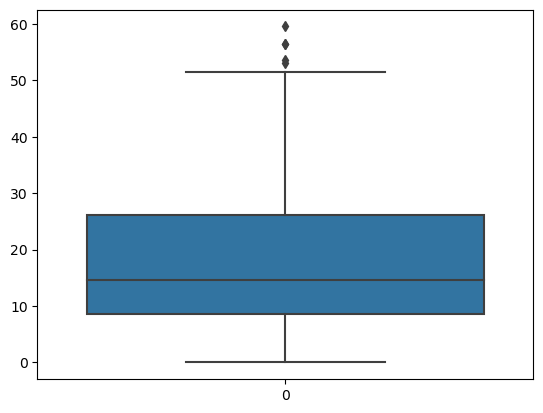

In [32]:
sns.boxplot(data_tt2['distance_in_km']) #Before treatment

In [33]:
### Find the percentage of outliers in distance_in_km column
outliers = find_outliers_IQR(data_tt2['distance_in_km'])
print("Outliers in Distance :\n",outliers)
print("Number of outliers in Distance : ",outliers.shape[0])
print("Percentage of outliers in Distance :", (outliers.shape[0]/data_tt2.shape[0])*100)

Outliers in Distance :
 196      59.538541
12938    56.494496
15667    56.494496
22541    53.589656
41050    53.043130
Name: distance_in_km, dtype: float64
Number of outliers in Distance :  5
Percentage of outliers in Distance : 0.014580660212294412


##### outliers in waiting_period_min

<Axes: >

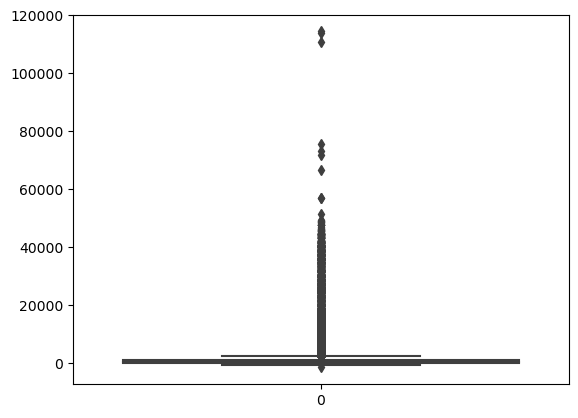

In [34]:
sns.boxplot(data_tt2['waiting_period_min']) #Before treatment

In [35]:
### Find the percentage of outliers in waiting_period_min column
outliers = find_outliers_IQR(data_tt2['waiting_period_min'])
print("Number of Outliers in Waiting Period : ",outliers.shape[0])
print("Percentage of outliers in Waiting Period : ", (outliers.shape[0]/data_tt2.shape[0])*100)

Number of Outliers in Waiting Period :  4613
Percentage of outliers in Waiting Period :  13.452117111862824


In [36]:
### Negative values in waiting_period_min are due to wrong data in from_date and booked_date, so dropping the respective data
print("Negative values in waiting_period_min - Before treatment : ",(data_tt2['waiting_period_min'] < 0).value_counts())
data_tt2.drop(data_tt2[data_tt2['waiting_period_min']<0].index,axis=0,inplace=True)

print("Negative values in waiting_period_min - After treatment : ",(data_tt2['waiting_period_min'] < 0).value_counts())

Negative values in waiting_period_min - Before treatment :  False    34267
True        25
Name: waiting_period_min, dtype: int64
Negative values in waiting_period_min - After treatment :  False    34267
Name: waiting_period_min, dtype: int64


##### outlier treatment for distance_in_km

In [37]:
### Percentage of outliers in the data is  less than 5%
### Outliers are only on the max side of the data, so replacing Outliers with Upper limit value

LL,UL = find_LL_UL(data_tt2['distance_in_km'])
print("Lower limit and Upper limit values: ",LL,UL)

data_tt2.loc[data_tt2['distance_in_km'] > UL,'distance_in_km'] = UL

Lower limit and Upper limit values:  -17.896080839403854 52.625168290999795


<Axes: >

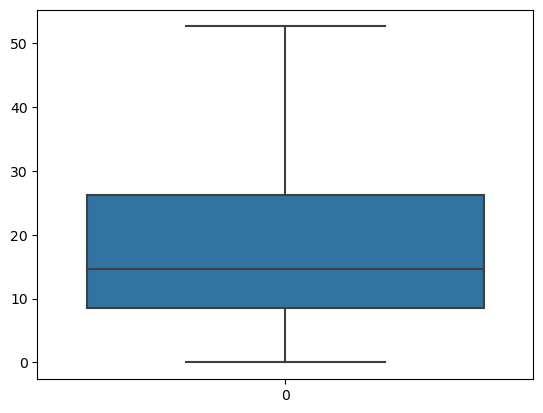

In [38]:
sns.boxplot(data_tt2['distance_in_km']) #After treatment

In [39]:
##### outlier treatment for waiting_period_min

In [40]:
### print("Outliers in waiting_period_min on the lower end before treatment: ",(data_tt2['waiting_period_min'] < 0).value_counts())

### LL,UL = find_LL_UL(data_tt2['waiting_period_min'])
### print("Outliers in waiting_period_min on the higher end before treatment: ",(data_tt2['waiting_period_min'] > UL).value_counts())

In [41]:
### Negative values in waiting_period_min are due to wrong data in from_date and booked_date, so dropping the respective data
### data_tt2.drop(data_tt2[data_tt2['waiting_period_min']<0].index,axis=0,inplace=True)
### print("Outliers in waiting_period_min on the lower end after treatment: ",(data_tt2['waiting_period_min'] < 0).value_counts()) ### Outliers on the lower end after treatment

In [42]:
### Outliers in waiting_period_min on the higher side more than 13%, so splitting data into with outliers and without outliers
### to build 2 models
### LL,UL = find_LL_UL(data_tt2['waiting_period_min'])
### data_tt2_wpol = data_tt2[data_tt2['waiting_period_min'] > UL] ### Data with outliers in waiting_period_min
### data_tt2 = data_tt2.drop(data_tt2[data_tt2['waiting_period_min']>UL].index,axis=0,inplace=True) ### Removing the outliers to get data without outliers in waiting_period_min


In [43]:
### sns.boxplot(data_tt2['waiting_period_min']) #After treatment

###### NOTE : Outliers for the remaining data in waiting_period_min would appear iteratively, so transformation and normalisation of the data is required rather to treat outliers

### Transformation of waiting_period_min using cbrt

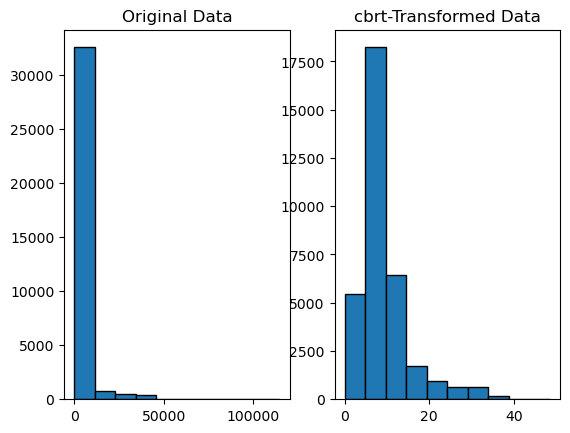

In [44]:
data = data_tt2['waiting_period_min']

# Perform cbrt transformation
data_log = np.cbrt(data)

# Create side-by-side histograms
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].hist(data, edgecolor='black')
axs[1].hist(data_log, edgecolor='black')
axs[0].set_title('Original Data')
axs[1].set_title('cbrt-Transformed Data')
plt.show()

In [45]:
data_tt2['waiting_period_min'] = data_log ### replace actual data with transformed data

<Axes: >

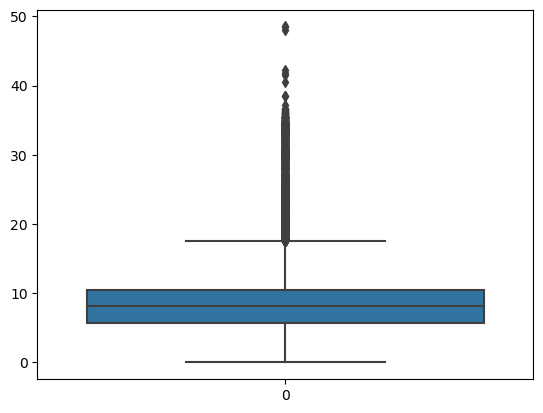

In [46]:
sns.boxplot(data_tt2['waiting_period_min']) ### before treatment after transformation

In [47]:
### Find the percentage of outliers in waiting_period_min column
outliers = find_outliers_IQR(data_tt2['waiting_period_min'])
print("Number of Outliers in Waiting Period : ",outliers.shape[0])
print("Percentage of outliers in Waiting Period : ", (outliers.shape[0]/data_tt2.shape[0])*100)

Number of Outliers in Waiting Period :  3018
Percentage of outliers in Waiting Period :  8.80730732191321


###### Outliers in waiting_period_min are >5% but <10%. So, replacing it with respective limit values

In [48]:
### Percentage of outliers in the data is  less than 5%
### Outliers are only on the max side of the data, so replacing Outliers with Upper limit value

LL,UL = find_LL_UL(data_tt2['waiting_period_min'])
print("Lower limit and Upper limit values: ",LL,UL)

data_tt2.loc[data_tt2['waiting_period_min'] > UL,'waiting_period_min'] = UL

Lower limit and Upper limit values:  -1.322484098611791 17.56138075233272


<Axes: >

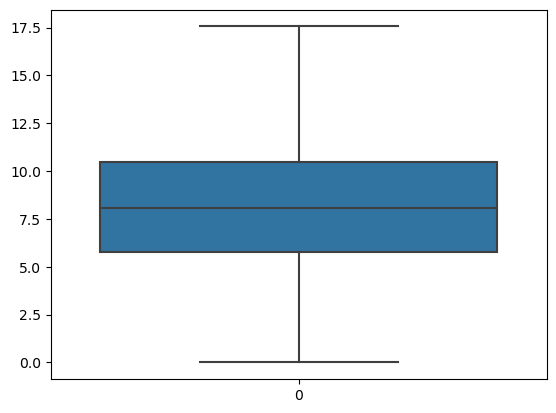

In [49]:
sns.boxplot(data_tt2['waiting_period_min'])     #after treatment after transformation

### Verify the pre processed data

In [50]:
data_tt2.shape

(34267, 12)

In [51]:
data_tt2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34267 entries, 0 to 43430
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   from_area_id        34267 non-null  float64
 1   to_area_id          34267 non-null  float64
 2   online_booking      34267 non-null  int64  
 3   Car_Cancellation    34267 non-null  int64  
 4   waiting_period_min  34267 non-null  float64
 5   travel_day          34267 non-null  int64  
 6   travel_month        34267 non-null  int64  
 7   booked_day          34267 non-null  int64  
 8   booked_month        34267 non-null  int64  
 9   travel_hour         34267 non-null  object 
 10  booked_hour         34267 non-null  object 
 11  distance_in_km      34267 non-null  float64
dtypes: float64(4), int64(6), object(2)
memory usage: 4.4+ MB


In [52]:
data_tt2.isnull().sum()

from_area_id          0
to_area_id            0
online_booking        0
Car_Cancellation      0
waiting_period_min    0
travel_day            0
travel_month          0
booked_day            0
booked_month          0
travel_hour           0
booked_hour           0
distance_in_km        0
dtype: int64

In [53]:
data_tt2.head()

,from_area_id,to_area_id,online_booking,Car_Cancellation,waiting_period_min,travel_day,travel_month,booked_day,booked_month,travel_hour,booked_hour,distance_in_km
0,83.0,448.0,0,0,2.758924,1,1,1,1,Late Night,Late Night,3.980687
1,1010.0,540.0,0,0,7.337234,1,1,1,1,Morning,Late Night,14.004432
2,1301.0,1034.0,0,0,2.802039,1,1,1,1,Late Night,Late Night,12.648909
3,768.0,398.0,0,0,4.041240,1,1,1,1,Early Morning,Late Night,9.534596
4,1365.0,849.0,0,0,4.061548,1,1,1,1,Morning,Early Morning,14.655467


In [54]:
data_tt2.describe(include='object')

,travel_hour,booked_hour
count,34267,34267
unique,6,6
top,Evening,Evening
freq,7809,8697


### Label encoding

In [55]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data_tt2['travel_hour'] = le.fit_transform(data_tt2['travel_hour'])
data_tt2['booked_hour'] = le.fit_transform(data_tt2['booked_hour'])
data_tt2.head()

,from_area_id,to_area_id,online_booking,Car_Cancellation,waiting_period_min,travel_day,travel_month,booked_day,booked_month,travel_hour,booked_hour,distance_in_km
0,83.0,448.0,0,0,2.758924,1,1,1,1,3,3,3.980687
1,1010.0,540.0,0,0,7.337234,1,1,1,1,4,3,14.004432
2,1301.0,1034.0,0,0,2.802039,1,1,1,1,3,3,12.648909
3,768.0,398.0,0,0,4.041240,1,1,1,1,1,3,9.534596
4,1365.0,849.0,0,0,4.061548,1,1,1,1,4,1,14.655467


### Correlation Analysis

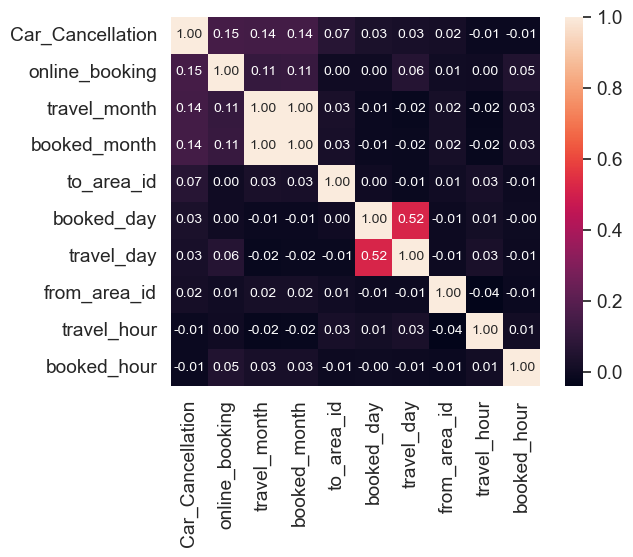

In [56]:
corrmat = data_tt2.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Car_Cancellation')['Car_Cancellation'].index
cm = np.corrcoef(data_tt2[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

###### NOTE : booked_month and travel_month are highly correlated, so dropping one of it (booked_month)

In [57]:
data_tt2 = data_tt2.drop(['booked_month'],axis=1)

### Extract features and target

In [58]:
x = data_tt2.iloc[:,data_tt2.columns != 'Car_Cancellation']
y = data_tt2.iloc[:,data_tt2.columns == 'Car_Cancellation']

### Scaling features before splitting

In [59]:
###Entire features scaling is required for some modelselections like KNN
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()

x_copy=x
x_ss=ss.fit_transform(x_copy)

In [60]:
y_ravel=y.values.ravel()

### Split data into training and test data

In [61]:
from sklearn.model_selection import train_test_split
#using stratify to have proportionate splitting in the data being selected
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,train_size=0.75, stratify=y)

In [62]:
y_test.shape

(8567, 1)

In [63]:
y_train.value_counts(normalize=True)*100

Car_Cancellation
0                   91.906615
1                    8.093385
dtype: float64

In [64]:
y_test=y_test.values.ravel()
#print(y_test)

In [65]:
#### y_train has severe improportion in the data so using Over sampling technique

In [66]:
#!pip install imblearn

#from imblearn.over_sampling import RandomOverSampler
#over=RandomOverSampler()
#x_train_over, y_train_over = over.fit_resample(x_train, y_train)

### Feature Scaling

In [67]:
standard_Scaler=StandardScaler()
x_train = standard_Scaler.fit_transform(x_train)
x_test = standard_Scaler.transform(x_test)

#### MinMax Scaler

In [88]:
from sklearn.preprocessing import MinMaxScaler
minmax_Scaler=MinMaxScaler()
xtrain_mm = minmax_Scaler.fit_transform(x_train)
xtest_mm = minmax_Scaler.transform(x_test)

In [68]:
y_train.value_counts(normalize=True)*100

Car_Cancellation
0                   91.906615
1                    8.093385
dtype: float64

In [69]:
y_train=y_train.values.ravel()

In [70]:
xtrain_ss=x_train
xtest_ss=x_test

ytrain=y_train
ytest=y_test

xtrain_mm=x_train
xtest_mm=x_test

### Random Forest Classifier

In [459]:
fit_rf = RandomForestClassifier(random_state=10)

### Hyper_Parameter Optimization Using GridSearchCV

In [460]:
np.random.seed(40)
start = time.time()

param_dist = {'max_depth':[2,3,4,5],
             'bootstrap':[True,False],
             'max_features':['auto','sqrt','log2',None],
             'criterion':['gini','entropy']}

cv_rf = GridSearchCV(fit_rf,cv=10,param_grid=param_dist,n_jobs=3)

cv_rf.fit(x_train,y_train)
print('Best Parameters using Grid search: \n',cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: %0.2f'%(end-start))

Best Parameters using Grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': None}
Time taken in grid search: 446.17


In [461]:
fit_rf.set_params(bootstrap=True, criterion = 'entropy',max_features = 'log2',max_depth = 5,random_state=4)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       random_state=4)

### OOB Rate

In [462]:
fit_rf.set_params(warm_start=True, 
                  oob_score=True)

min_estimators = 10
max_estimators = 500

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    fit_rf.set_params(n_estimators=i)
    fit_rf.fit(x_train, y_train)

    oob_error = 1 - fit_rf.oob_score_
    error_rate[i] = oob_error

C:\Users\meetr\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\meetr\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\meetr\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\meetr\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\meetr\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probab

In [463]:
oob_series = pd.Series(error_rate)
oob_series[oob_series == oob_series.min()].index[0]

14

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 10 to 500 Trees)')

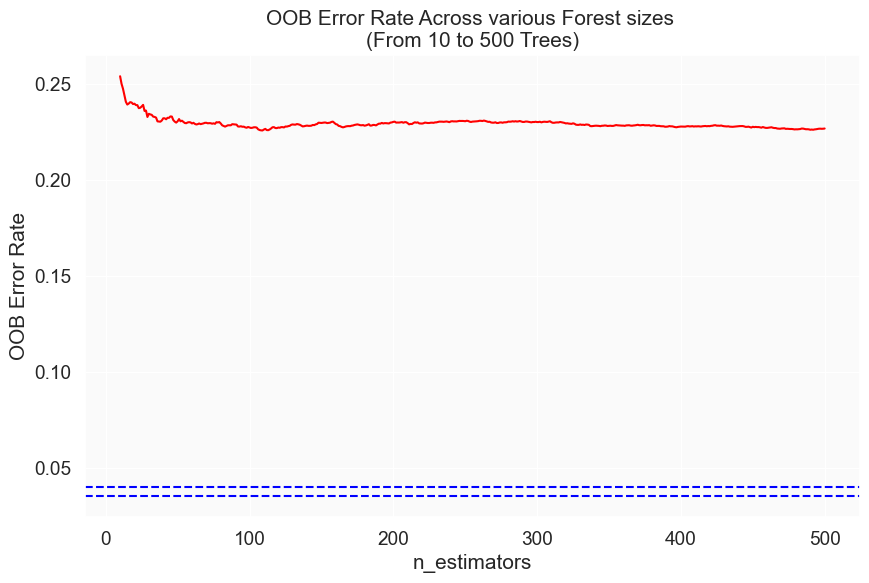

In [418]:
fig, ax = plt.subplots(figsize=(10,6))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')
plt.axhline(0.035,color='blue',linestyle='--')
plt.axhline(0.04,color='blue',linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 10 to 500 Trees)')

In [497]:
print('OOB Error rate for 14 trees is: %0.5f'%oob_series[14])

OOB Error rate for 14 trees is: 0.08082


In [499]:
fit_rf.set_params(n_estimators=14,bootstrap=True,warm_start=False,oob_score=False)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       n_estimators=14, random_state=4)

### Train The Random Forest

In [500]:
fit_rf.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       n_estimators=14, random_state=4)

### Predictions

In [501]:
y_pred = fit_rf.predict(x_test)

In [517]:
np.set_printoptions(threshold=np.inf)
y_pred[:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [516]:
y_test[:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

### Confusion Matrix

In [515]:
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

Confusion Matrix:
 [[7873    0]
 [ 694    0]]


In [506]:
accuracy_rf = fit_rf.score(x_test,y_test)
print("Here our Accuracy of model is: %0.5f"%accuracy_rf)

Here our Accuracy of model is: 0.91899


In [507]:
test_error_rate_rf = 1-accuracy_rf
print("error rate of our model is: %0.5f"%test_error_rate_rf)

error rate of our model is: 0.08101


In [508]:
# We grab the second array from the output which corresponds to
# to the predicted probabilites of positive classes 
predictions_prob = fit_rf.predict_proba(x_test)[:, 1]

fpr2, tpr2, _ = roc_curve(y_test,
                          predictions_prob,
                          pos_label = 1)

In [509]:
auc_rf = auc(fpr2,tpr2)

In [510]:
def plot_roc_curve(fpr, tpr, auc, estimator, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph

    Parameters
    ----------
    * fpr: Array returned from sklearn.metrics.roc_curve for increasing
            false positive rates
    * tpr: Array returned from sklearn.metrics.roc_curve for increasing
            true positive rates
    * auc: Float returned from sklearn.metrics.auc (Area under Curve)
    * estimator: String represenation of appropriate model, can only contain the
    following: ['knn', 'rf', 'nn']
    * xlim: Set upper and lower x-limits
    * ylim: Set upper and lower y-limits
    """
    my_estimators = {'knn': ['Kth Nearest Neighbor', 'deeppink'],
              'rf': ['Random Forest', 'red'],
              'nn': ['Neural Network', 'purple']}

    try:
        plot_title = my_estimators[estimator][0]
        color_value = my_estimators[estimator][1]
    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
\nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
             color=color_value,
             linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f})'\
              .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()

C:\Users\meetr\AppData\Local\Temp\ipykernel_17268\2183041405.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
C:\Users\meetr\AppData\Local\Temp\ipykernel_17268\2183041405.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')


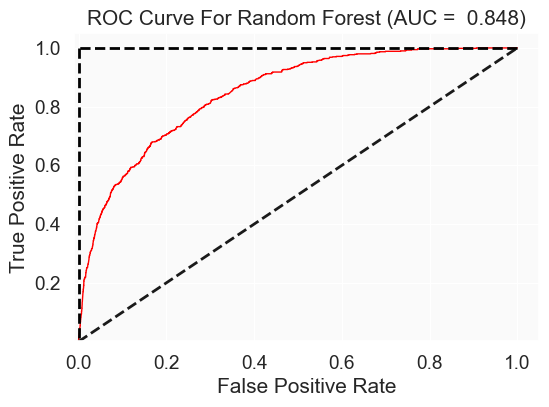

In [511]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

In [512]:
def print_class_report(predictions, alg_name):
    """
     Purpose
    ----------
    Function helps automate the report generated by the
    sklearn package. Useful for multiple model comparison

    Parameters:
    ----------
    predictions: The predictions made by the algorithm used
    alg_name: String containing the name of the algorithm used
    
    Returns:
    ----------
    Returns classification report generated from sklearn.
    """
    print('Classification Report for %s: '%alg_name)
    print(classification_report(predictions, y_test, target_names = ['Not Cancelled','Cancelled']))

In [513]:
class_report = print_class_report(y_pred,'Random Forest')

Classification Report for Random Forest: 
               precision    recall  f1-score   support

Not Cancelled       1.00      0.92      0.96      8567
    Cancelled       0.00      0.00      0.00         0

     accuracy                           0.92      8567
    macro avg       0.50      0.46      0.48      8567
 weighted avg       1.00      0.92      0.96      8567



C:\Users\meetr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meetr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meetr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


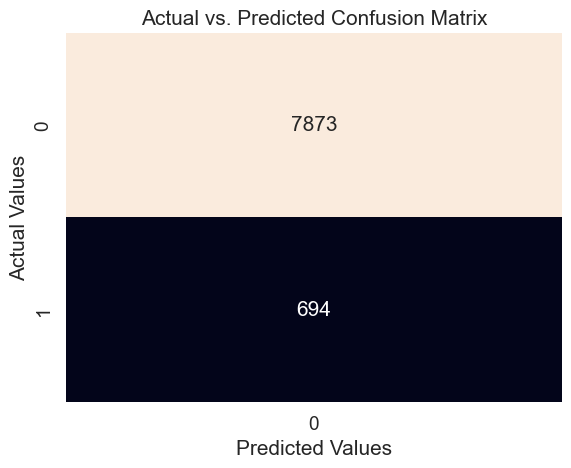

In [505]:
conf_mat = create_conf_mat(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

### SVM Model

In [109]:
start=time.time()

from sklearn.svm import SVC

svm=SVC()

## Hyper_parameter optimisation using Grid Search CV
def svm_model_gridsearch(xtrain,ytrain):
    # Define the hyperparameter grid
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf','poly','linear']}
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', verbose=0,cv=5)
    grid_search.fit(xtrain,ytrain)
    return grid_search.best_params_

def svm_model(xtrain,xtest,ytrain):
    best_params = svm_model_gridsearch(xtrain,ytrain)
    best_svm = SVC(**best_params, probability=True)
    best_svm.fit(xtrain, ytrain)
    y_predict=best_svm.predict(xtest)
    y_predictproba=best_svm.predict_proba(xtest)[::,1]
    return [y_predict,y_predictproba,best_params]

def svm_model_metrices(ytest,ypredict):
    con_matrix=confusion_matrix(ytest,ypredict)
    accur=accuracy_score(ytest,ypredict)
    classf_report=classification_report(ytest,ypredict)
    f1_scr=f1_score(ytest,ypredict)
    return [con_matrix,accur,classf_report,f1_scr]

##### SVM model evaluation with Standard Scaled features

C:\Users\meetr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meetr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\meetr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


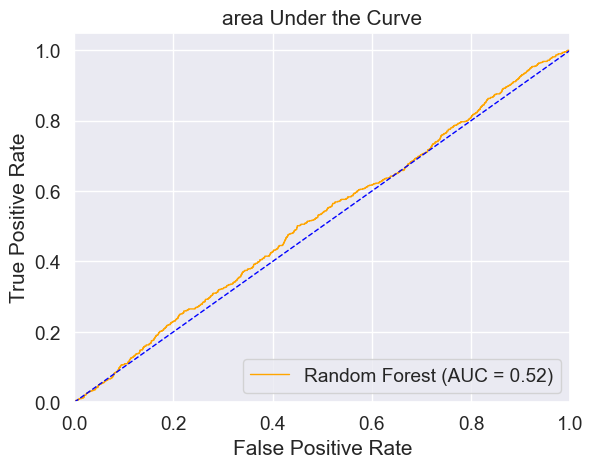

accuracy=  {0.9189914789307809} 

confusion_matrix= 
 [[7873    0]
 [ 694    0]] 

classification report= 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96      7873
           1       0.00      0.00      0.00       694

    accuracy                           0.92      8567
   macro avg       0.46      0.50      0.48      8567
weighted avg       0.84      0.92      0.88      8567

f1 score =  0.0


In [110]:
y=svm_model(xtrain_ss,xtest_ss,ytrain)

svm_metrices=svm_model_metrices(ytest,y[0])
end=time.time()

### Calculation of AUC and ROC
fpr,tpr,_= roc_curve(ytest,y[1])
auc_val = roc_auc_score(ytest,y[1])
roc_auc_val = auc(fpr,tpr)

### Plotting ROC
plt.figure(1)
lw=1
plt.plot(fpr,tpr,color='orange',lw=lw,label='Random Forest (AUC = %0.2f)'%roc_auc_val)
plt.plot([0,1],[0,1],color='blue',lw=lw,linestyle='--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("area Under the Curve")
plt.legend(loc="lower right")
plt.show()

### Printing metrices
print(f'accuracy= ',{svm_metrices[1]},'\n')
print(f'confusion_matrix= \n',svm_metrices[0],'\n')
print(f'classification report= \n',svm_metrices[2])
print(f'f1 score = ',svm_metrices[3])
time_taken=end-start

models_res.append(['SVM - MinMax Scaler',svm_metrices[1],auc_val,svm_metrices[3],time_taken,y[2]])